In [1]:
%pip install davos
import davos

davos.config.suppress_stdout = True

Note: you may need to restart the kernel to use updated packages.


In [2]:
smuggle numpy as np               # pip: numpy==1.24.2
smuggle matplotlib.pyplot as plt  # pip: matplotlib==3.7.0
smuggle pandas as pd              # pip: pandas==1.5.3
smuggle seaborn as sns            # pip: seaborn==0.12.2
smuggle requests                  # pip: requests==2.28.2
from tqdm smuggle tqdm            # pip: tqdm==4.64.1
from PIL smuggle Image            # pip: Pillow==9.4.0
from scipy.spatial.distance smuggle pdist, squareform      # pip: scipy==1.10.1
from scipy.stats smuggle ttest_ind

import os
import shutil
from glob import glob as lsdir

from helpers import basedir, figdir, plot_colorbar

Unzip stimulus directory, load faces and places

In [3]:
exp_dir = os.path.join(basedir, 'experiment')

stim_fname = os.path.join(exp_dir, 'stimuli.zip')
shutil.unpack_archive(stim_fname, exp_dir)

faces = [Image.open(im) for im in lsdir(os.path.join(exp_dir, 'stimuli', 'faces', '*.jpg'))]
places = [Image.open(im) for im in lsdir(os.path.join(exp_dir, 'stimuli', 'places', '*.jpg'))]

# Figure 3A

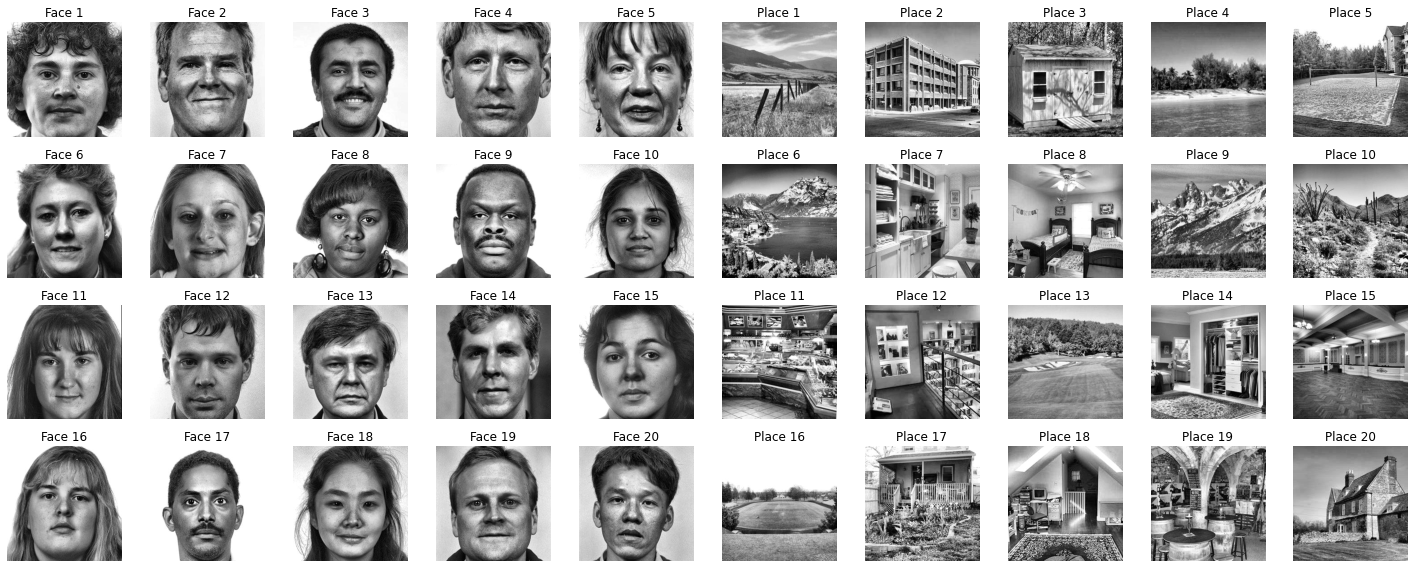

In [4]:
category_rows = 4
category_cols = 5

fig, axes = plt.subplots(category_rows, 2 * category_cols, figsize=(2 * category_cols * 2, 2 * category_rows))

# show faces
i = 0
for x in range(category_rows):
    for y in range(category_cols):
        ax = axes[x, y]
        ax.imshow(faces[i], cmap='gray')
        ax.axis('off')
        ax.set_title(f'Face {i + 1}', fontsize=12)
        i += 1

# show places
i = 0
for x in range(category_rows):
    for y in range(category_cols):
        ax = axes[x, y + category_cols]
        ax.imshow(places[i], cmap='gray')
        ax.axis('off')
        ax.set_title(f'Place {i + 1}', fontsize=12)
        i += 1

plt.tight_layout()

fig.savefig(os.path.join(figdir, 'stimulus_examples.pdf'), bbox_inches='tight')

# Figure 3B

In [5]:
def average_image(images):
    return np.mean(np.array([np.array(im) for im in images]), axis=0)

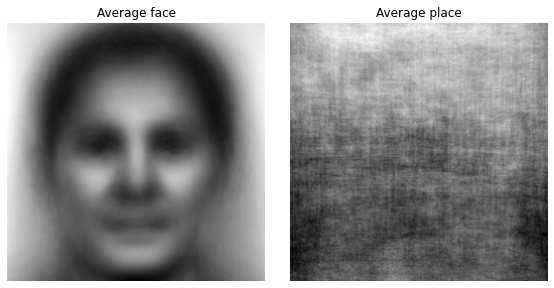

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# show average face
ax[0].imshow(average_image(faces), cmap='gray')
ax[0].axis('off')
ax[0].set_title('Average face', fontsize=12)

# show average place
ax[1].imshow(average_image(places), cmap='gray')
ax[1].axis('off')
ax[1].set_title('Average place', fontsize=12)

plt.tight_layout()

fig.savefig(os.path.join(figdir, 'average_stimuli.pdf'), bbox_inches='tight')

# Pairwise similarities

In [7]:
face_array = np.concatenate([np.atleast_2d(np.array(f).flatten()) for f in faces], axis=0)
place_array = np.concatenate([np.atleast_2d(np.array(p).flatten()) for p in places], axis=0)

face_correlations = 1 - squareform(pdist(face_array, metric='correlation'))
place_correlations = 1 - squareform(pdist(place_array, metric='correlation'))

# Figure 3C

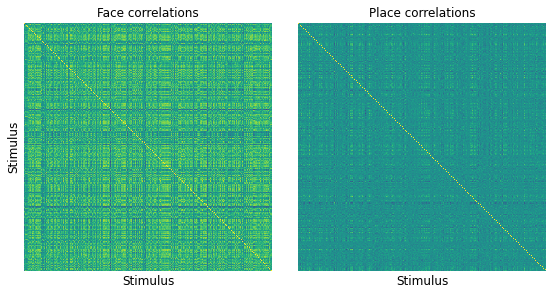

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

sns.heatmap(face_correlations, cmap='viridis', square=True, vmin=-1, vmax=1, ax=ax[0], cbar=False)
ax[0].set_title('Face correlations', fontsize=12)
ax[0].set_xlabel('Stimulus', fontsize=12)
ax[0].set_ylabel('Stimulus', fontsize=12)
ax[0].set_yticks([])
ax[0].set_xticks([])

sns.heatmap(place_correlations, cmap='viridis', square=True, vmin=-1, vmax=1, ax=ax[1], cbar=False)
ax[1].set_title('Place correlations', fontsize=12)
ax[1].set_xlabel('Stimulus', fontsize=12)
ax[1].set_yticks([])
ax[1].set_xticks([])

plt.tight_layout()

fig.savefig(os.path.join(figdir, 'stimulus_correlations.pdf'), bbox_inches='tight')

In [9]:
plot_colorbar('viridis', 'viridis')

In [10]:
correlations = pd.DataFrame.from_dict({'Face correlations': 1 - squareform(1 - face_correlations), 'Place correlations': 1 - squareform(1 - place_correlations)})
correlations.head()

,Face correlations,Place correlations
0,-0.120210,0.039096
1,-0.168679,-0.056360
2,0.018609,0.146835
3,0.242033,0.137588
4,0.135470,0.204285


# Figure 3D

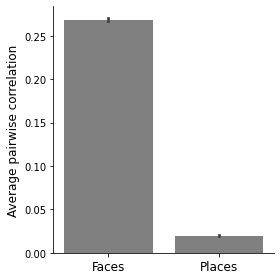

In [11]:
fig = plt.figure(figsize=(4, 4))

sns.barplot(data=correlations, color='gray')
plt.ylabel('Average pairwise correlation', fontsize=12)
plt.gca().set_xticklabels(['Faces', 'Places'], fontsize=12)
sns.despine(top=True, right=True)

plt.tight_layout()

fig.savefig(os.path.join(figdir, 'stimulus_correlations_barplot.pdf'), bbox_inches='tight')

# Stimulus-related statistical test

Compare pairwise similarities of face and place images

In [12]:
result = ttest_ind(correlations['Face correlations'], correlations['Place correlations'])

if result.pvalue < 0.001:
    p_string = 'p < 0.001'
else:
    p_string = f'p = {result.pvalue:.3f}'
print(f'$t({correlations.shape[0] * 2 - 2}) = {result.statistic:.3f}, {p_string}$')


$t(115258) = 254.764, p < 0.001$
